In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from gwak.train.dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
data_dir = "/home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/test"
sample_rate = 4096
kernel_length = 0.5
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 512
batches_per_epoch = 10
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None
]

In [58]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)
test_loader = loader.test_dataloader()

None True
{'ringdown_duration': 0.9} False
None True
None True
None True
None True
None True
None True


In [59]:
for batch in test_loader:
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    break

In [60]:
from gwak.train.cl_models import Crayon
import yaml

ckpt = "../../output/S4_SimCLR_multiSignalAndBkg/lightning_logs/8wuhxd59/checkpoints/47-2400.ckpt"
cfg_path = "../../output/S4_SimCLR_multiSignalAndBkg/config.yaml"
with open(cfg_path,"r") as fin:
    cfg = yaml.load(fin,yaml.FullLoader)

model = Crayon.load_from_checkpoint(ckpt,**cfg['model']['init_args'])
model = model.eval()

In [61]:
tot = 0
output = []
labs = []
for batch in tqdm(test_loader):
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    
    with torch.no_grad():
        y = model.model(x).cpu().numpy()
    
    output.append(y)
    labs.append(labels.cpu().numpy())
    
    tot += y.shape[0]

l = np.concatenate(labs)
y = np.concatenate(output,axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:34<00:00, 21.42s/it]


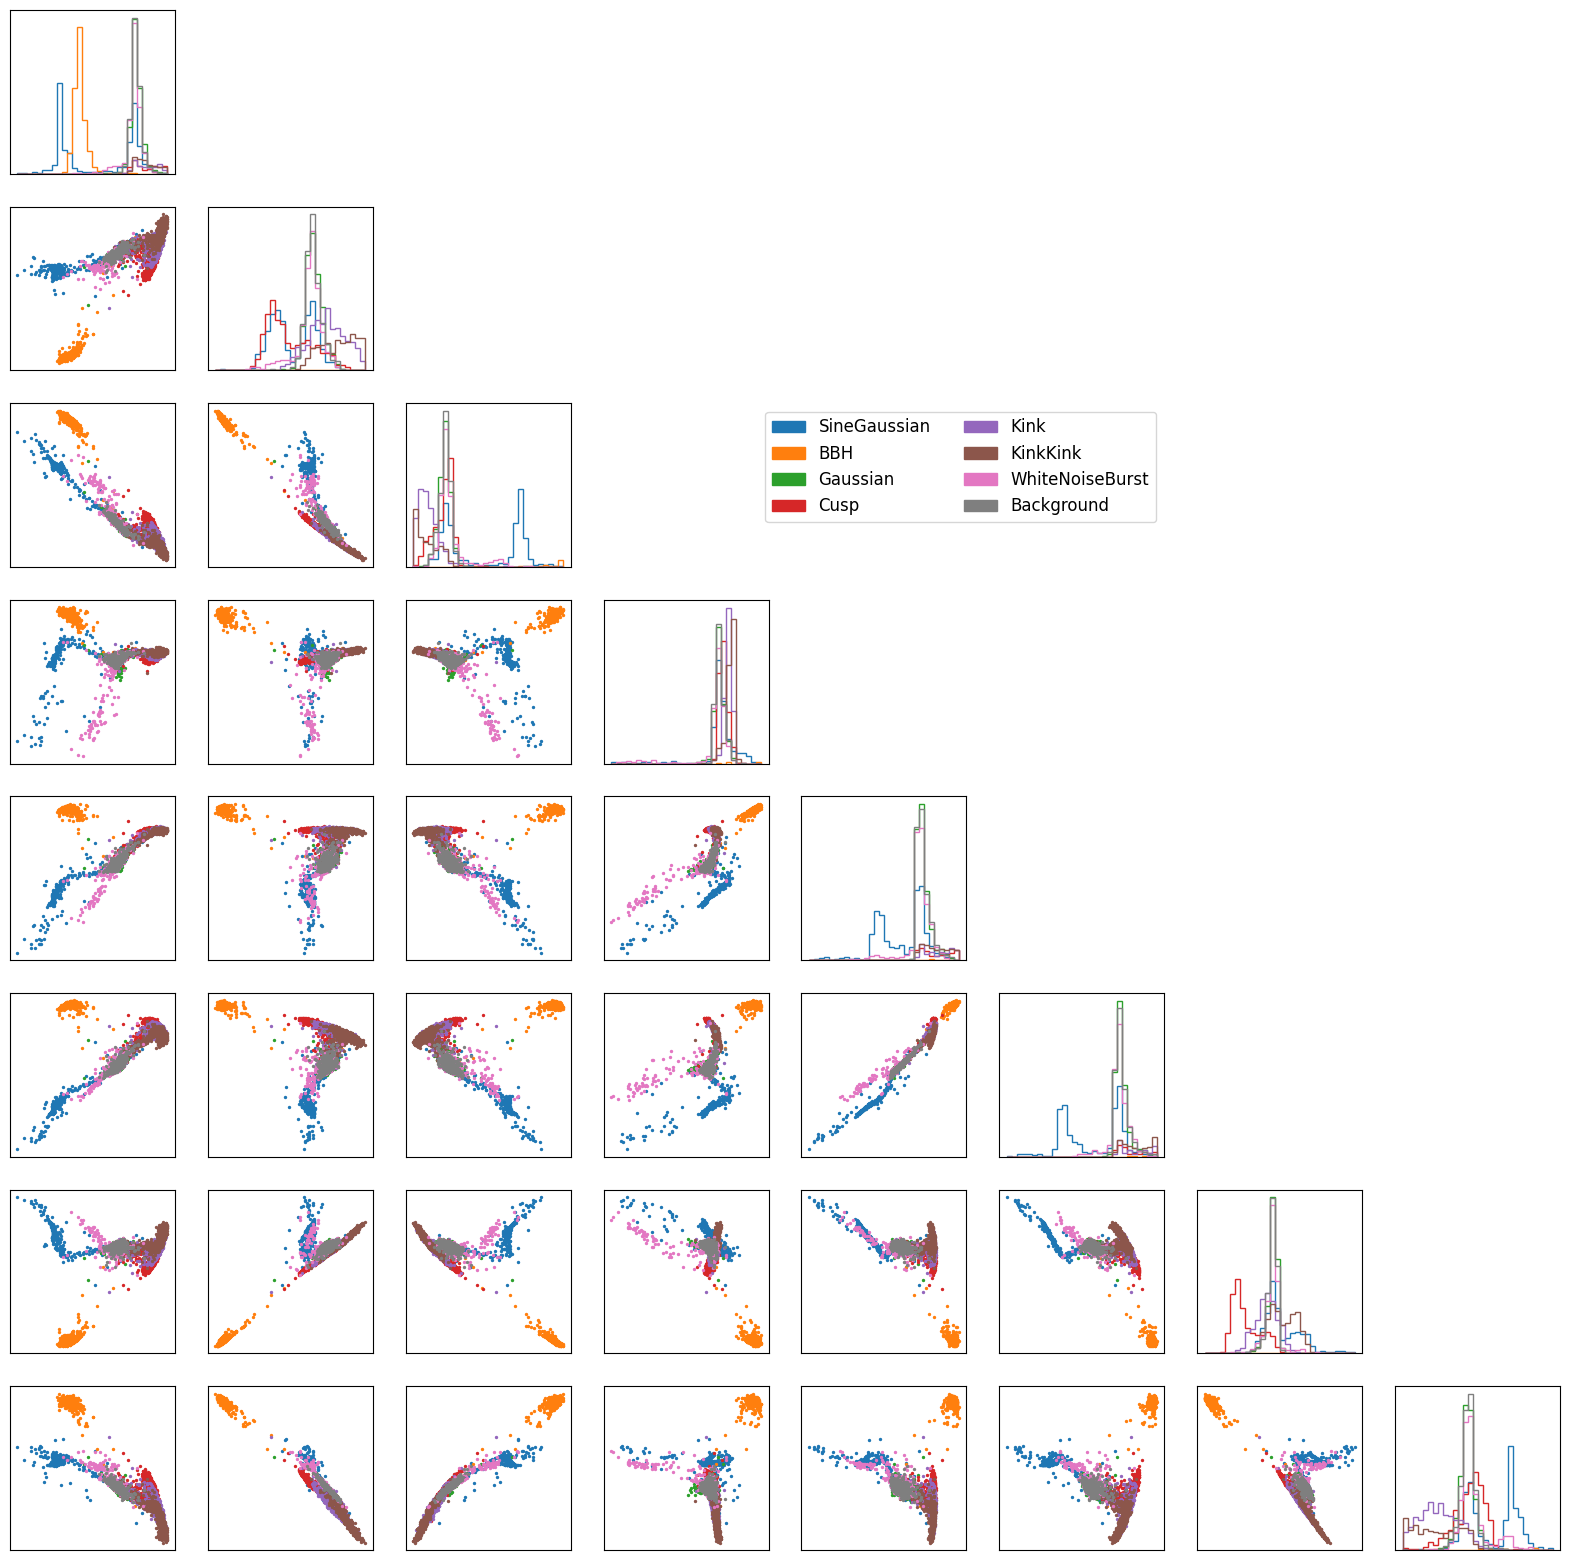

In [62]:
#import corner

N = y.shape[1]
labs_uniq = sorted(list(set(l)))
fig,axes = plt.subplots(N,N,figsize=(20,20))

for i in range(y.shape[1]):
    for j in range(i+1,y.shape[1]):
        plt.sca(axes[i,j])
        plt.axis('off')

for i in range(y.shape[1]):
    plt.sca(axes[i,i])
    plt.xticks([])
    plt.yticks([])
    bins = 30
    for j,lab in enumerate(labs_uniq):
        h,bins,_ = plt.hist(y[l==lab][:,i],bins=bins,histtype='step',color=f"C{j}")
        
for i in range(1,y.shape[1]):
    for j in range(i):
        plt.sca(axes[i,j])
        plt.xticks([])
        plt.yticks([])
        for k,lab in enumerate(labs_uniq):
            ysel = y[l==lab]
            plt.scatter(ysel[:,j],ysel[:,i],s=2,color=f"C{k}")
            
from matplotlib.patches import Patch
plt.sca(axes[2,5])
patches = []
for k,lab in enumerate(labs_uniq):
    patches.append(Patch(color=f"C{k}",label=signal_classes[k]))
plt.legend(handles=patches,ncol=2,fontsize=12)

#plt.tight_layout()

#for i,lab in enumerate(sorted(list(set(l)))):
#    corner.corner(y[l==lab],fig=fig,color=f"C{i}")

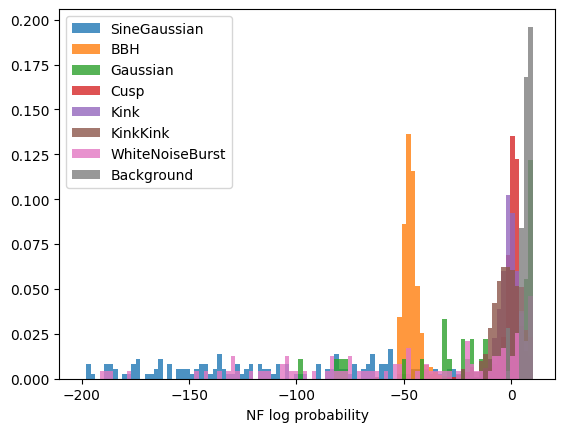

In [63]:
flow = torch.jit.load("../../output/NF_onlyBkg/model_JIT.pt")
flow.eval()
for i, c in enumerate(signal_classes):
    ysel = y[l==i+1]
    plt.hist(flow(torch.from_numpy(ysel)).detach().numpy(), bins=100, range=(-200,10.), label=c, density=True, alpha=0.8)

plt.xlabel("NF log probability")
plt.legend()  

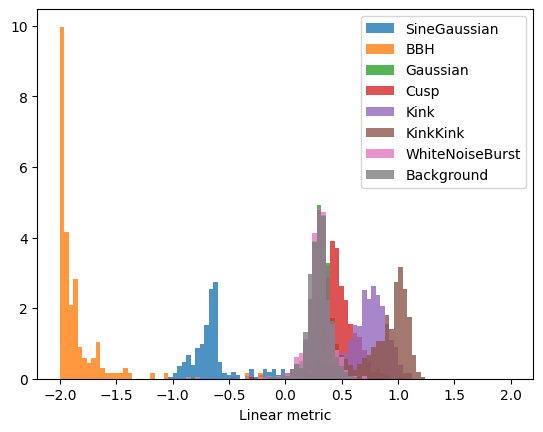

In [64]:
linear = torch.jit.load("../../output/linear_metric/SimCLR_multiSignal_all/linear_model_JIT.pt")
for i, c in enumerate(signal_classes):
    ysel = y[l==i+1]
    plt.hist(linear(torch.from_numpy(ysel)).detach().numpy(), bins=100, range=(-2,2.), label=c, density=True, alpha=0.8)

plt.xlabel("Linear metric")
plt.legend()  

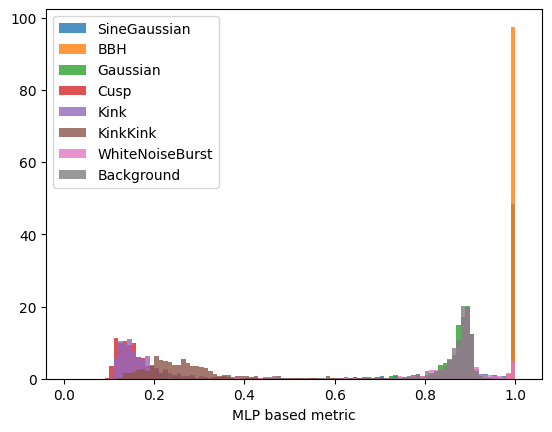

In [65]:
linear = torch.jit.load("../../output/linear_metric/SimCLR_multiSignal_all/mlp_model_JIT.pt")
for i, c in enumerate(signal_classes):
    ysel = y[l==i+1]
    plt.hist(linear(torch.from_numpy(ysel)).detach().numpy(), bins=100, range=(0.01,1.01), label=c, density=True, alpha=0.8)

plt.xlabel("MLP based metric")
plt.legend()  